**Creation Date:**

**September 18, 2020**


**created by Engin Deniz ALPMAN**



# Yes Initialization Matters

## Same stuffs that we saw previous notebooks

In [1]:
import torch
import torch.nn as nn
from PIL import Image
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt

import os
import math

In [118]:
import torch.nn.init as init

In [2]:
import torch.nn.functional as F

In [3]:
PATH= Path("D:/python projects/lectures/102/NN from Scratch/data/mnist")

In [4]:
def log_softmax(x): 
    return (x.exp()/(x.exp().sum(-1,keepdim=True)) + 1e-20).log()

In [5]:
def nll(preds, actuals): 
    return -preds[range(actuals.shape[0]), actuals].mean()

In [6]:
def validation_acc(model):
    return torch.stack([accuracy(model(xb), yb) for xb, yb in valid_dl]).mean().item()

In [7]:
def accuracy(preds, yb): 
    return (torch.argmax(preds, dim=1, keepdim = True)==yb).float().mean()

In [8]:
def loss_func(preds, targets):
    preds = log_softmax(preds)
    return nll(preds, targets)

In [9]:
def train(model, epochs=5, valid_epoch=5):
    for epoch in range(epochs):
        for xb, yb in train_dl:
            
            preds = model(xb)
            loss = loss_func(preds, yb.squeeze())
            loss.backward()
            optim.step()
            optim.zero_grad()
        
        if epoch % valid_epoch == 0:
            print(validation_acc(model))

In [10]:
def _get_files(p, fs, extensions = None):
    p = Path(p) # to support / notation
    res = [p/f for f in fs if not f.startswith(".") 
           and ((not extensions) or f'.{f.split(".")[-1].lower()}' in extensions)]
    return res

In [11]:
class Dataset():
    def __init__(self, x, y): 
        self.x,self.y = x,y
    def __len__(self): 
        return len(self.x)
    def __getitem__(self, i): 
        return self.x[i].cuda(),self.y[i].cuda()


class DataLoader():
    def __init__(self, ds, bs): 
        self.ds, self.bs = ds, bs
    def __iter__(self):
        n = len(self.ds)
        l = torch.randperm(n)

        
        for i in range(0, n, self.bs): 
            idxs_l = l[i:i+self.bs]
            yield self.ds[idxs_l]

In [12]:
def create_ds_from_file(src):
    imgs, labels = [], []
    
    for label in range(10):
        path = src/str(label)
        print(path)
        t = [o.name for o in os.scandir(path)]
        t = _get_files(path, t, extensions = [".jpg", ".png"])
        for e in t:
            l = [np.array(Image.open(e)).reshape(28*28)]
            imgs += l
        labels += ([label] * len(t))
    return torch.tensor(imgs,  dtype=torch.float32), torch.tensor(labels, dtype=torch.long).view(-1,1)

In [40]:
trn_x, trn_y = create_ds_from_file(PATH/"train")

D:\python projects\lectures\102\NN from Scratch\data\mnist\train\0
D:\python projects\lectures\102\NN from Scratch\data\mnist\train\1
D:\python projects\lectures\102\NN from Scratch\data\mnist\train\2
D:\python projects\lectures\102\NN from Scratch\data\mnist\train\3
D:\python projects\lectures\102\NN from Scratch\data\mnist\train\4
D:\python projects\lectures\102\NN from Scratch\data\mnist\train\5
D:\python projects\lectures\102\NN from Scratch\data\mnist\train\6
D:\python projects\lectures\102\NN from Scratch\data\mnist\train\7
D:\python projects\lectures\102\NN from Scratch\data\mnist\train\8
D:\python projects\lectures\102\NN from Scratch\data\mnist\train\9


In [41]:
val_x,val_y = create_ds_from_file(PATH/"validation")

D:\python projects\lectures\102\NN from Scratch\data\mnist\validation\0
D:\python projects\lectures\102\NN from Scratch\data\mnist\validation\1
D:\python projects\lectures\102\NN from Scratch\data\mnist\validation\2
D:\python projects\lectures\102\NN from Scratch\data\mnist\validation\3
D:\python projects\lectures\102\NN from Scratch\data\mnist\validation\4
D:\python projects\lectures\102\NN from Scratch\data\mnist\validation\5
D:\python projects\lectures\102\NN from Scratch\data\mnist\validation\6
D:\python projects\lectures\102\NN from Scratch\data\mnist\validation\7
D:\python projects\lectures\102\NN from Scratch\data\mnist\validation\8
D:\python projects\lectures\102\NN from Scratch\data\mnist\validation\9


In [42]:
# there is little error here, can you spot it ?
mean = trn_x.mean()
std = trn_x.std()

trn_x=(trn_x-mean)/std
mean, std, trn_x.mean(), trn_x.std()

(tensor(34.3409), tensor(77.5014), tensor(7.4670e-06), tensor(1.))

In [43]:
val_x = (val_x-mean)/std
val_x.mean(), val_x.std()

(tensor(0.0042), tensor(1.0038))

In [44]:
class Dataset():
    def __init__(self, x, y): 
        self.x,self.y = x,y
    def __len__(self): 
        return len(self.x)
    def __getitem__(self, i): 
        return self.x[i].view(-1,1,28,28).cuda(),self.y[i].cuda()


class DataLoader():
    def __init__(self, ds, bs): 
        self.ds, self.bs = ds, bs
    def __iter__(self):
        n = len(self.ds)
        l = torch.randperm(n)

        
        for i in range(0, n, self.bs): 
            idxs_l = l[i:i+self.bs]
            yield self.ds[idxs_l]

In [45]:
train_ds = Dataset(trn_x, trn_y)
valid_ds = Dataset(val_x,val_y)

In [46]:
train_dl = DataLoader(train_ds, 256)
valid_dl = DataLoader(valid_ds, 256)

## nn.Conv2d init problem

* The important thing is not holding std and mean 1 and 0, important thing is to hold them constant (we will change that with batchnorm though) so that they will not be too big or too small and hinder learning

In [152]:
a = np.random.normal(size = 300 )

In [153]:
stats(a)

Mean: 0.008965392212481684, Std: 0.9769349651094105


In [154]:
b = np.random.normal(size = 300)

In [155]:
stats(b)

Mean: 0.06700045940437285, Std: 1.0420360927698915


In [156]:
c = a * b

In [157]:
stats(c)

Mean: -0.04734953395947398, Std: 0.9724765460576855


In [484]:
torch.nn.modules.conv._ConvNd.reset_parameters??

* At initializing conv2d weights, there is $\sqrt{5}$ coefficient, and it is not working well

* The important thing is not having mean of 0 and std of 1, the important thing is to keep them constant across the network, so you can choose to have mean of 2 and std of 3 (but keep in mind that some values may work better for activation functions, so be careful of network design) but you should preserve it so that it will not be too variant

* If std is close to 0, nodes will be very similar, so there is not much variation and nodes are learning same things

* If std is high, network may have a hard time adapting learning bigger range. Also small change in weights may result in very big change in output since variances add

In [203]:
x, y = next(iter(train_dl))

In [204]:
x.shape

torch.Size([256, 1, 28, 28])

In [205]:
y.shape

torch.Size([256, 1])

### Default Inıt

In [284]:
l1 = nn.Conv2d(1, 32, kernel_size= 5).cuda()

In [286]:
def stats(x):
    print(f"Mean: {x.mean()}, Std: {x.std()}")

In [287]:
stats(x)

Mean: 0.003263120772317052, Std: 1.0004709959030151


In [288]:
l1.weight.shape, l1.bias.shape

(torch.Size([32, 1, 5, 5]), torch.Size([32]))

In [289]:
stats(l1.weight)
stats(l1.bias)

Mean: 0.0016191889299079776, Std: 0.11515535414218903
Mean: -0.00017804140225052834, Std: 0.10069632530212402


In [290]:
a1 = l1(x)

In [291]:
stats(a1)

Mean: 0.006427197717130184, Std: 0.5973247289657593


* Default init preseve 0 mean but halved the std, if we keep doing that in higher layers too, it can make our std near to 0 and hinder learning

In [292]:
l2 = nn.Conv2d(32, 32, kernel_size= 5).cuda()

In [293]:
a2 = l2(a1)

In [294]:
stats(a2)

Mean: -0.02455059625208378, Std: 0.4184928238391876


* As we can see above, second layer made std even lower

### Just Initialize from normal distribution

In [295]:
l1.weight.data = init.normal_(l1.weight.data)

In [298]:
stats(l1.weight)

Mean: -0.05051687732338905, Std: 1.0209805965423584


In [299]:
a1 = l1(x)

In [301]:
stats(a1)

Mean: -0.19589215517044067, Std: 6.08129358291626


* Variances added, so we could not preserve std of 1

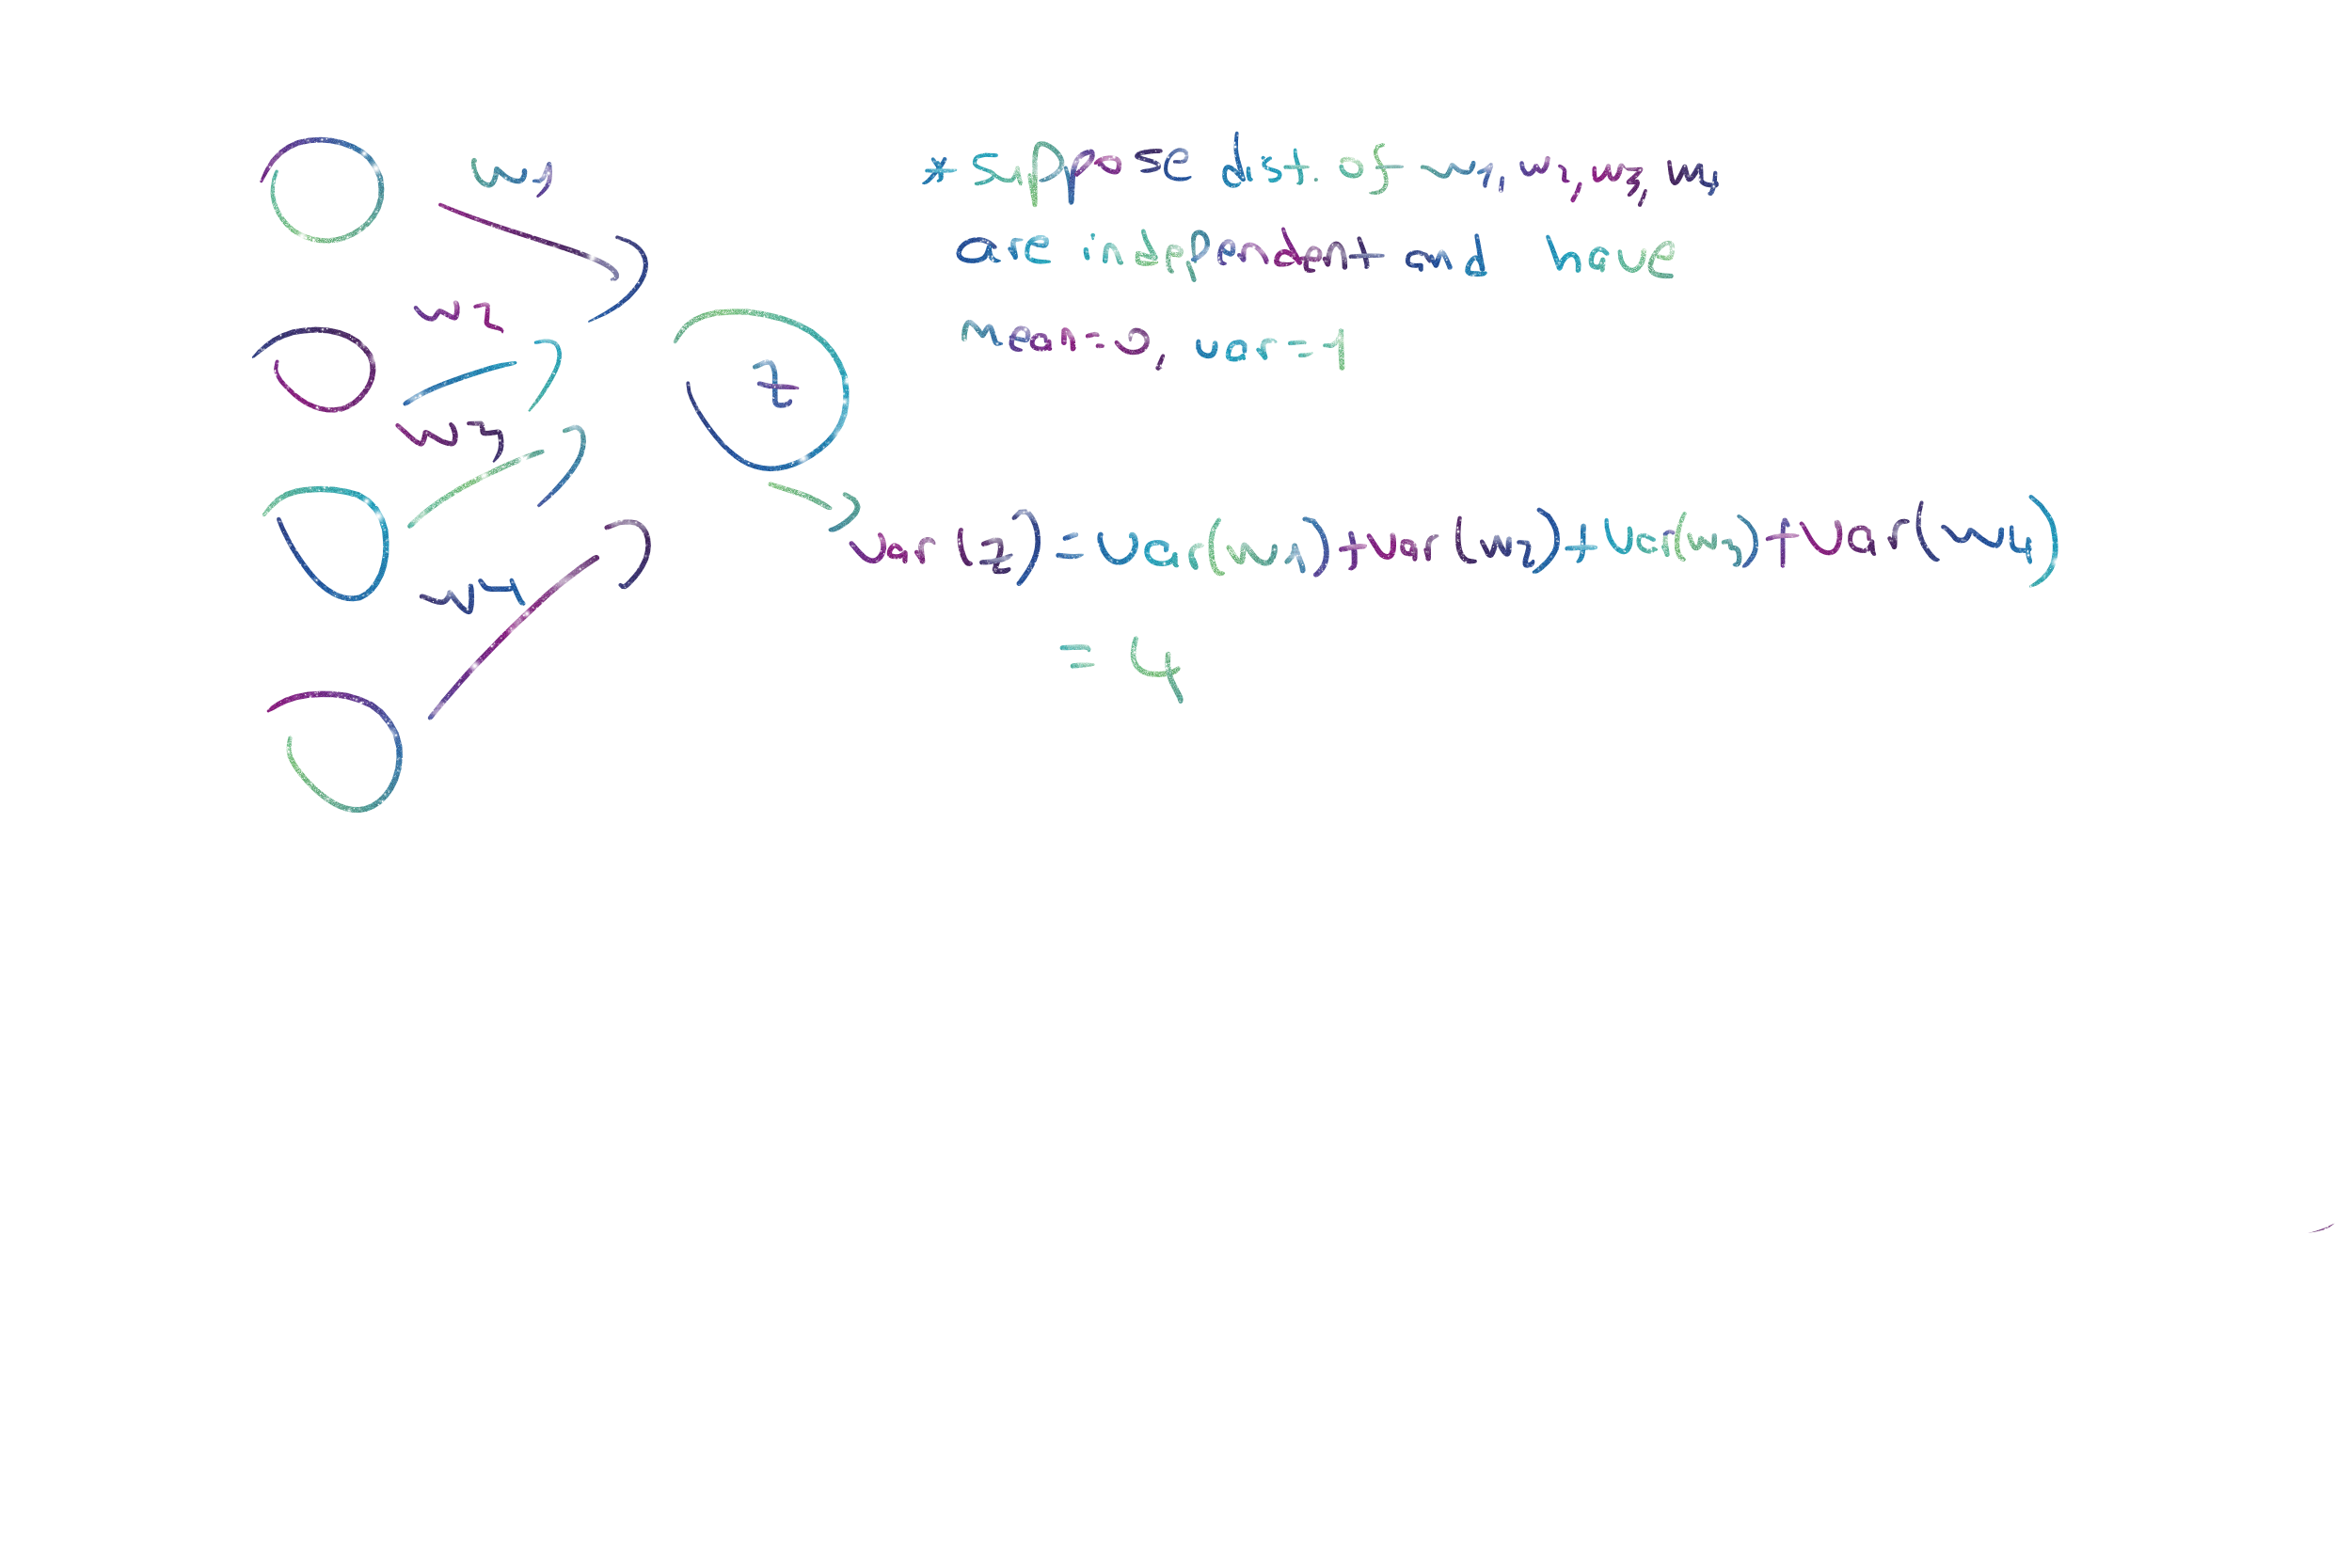

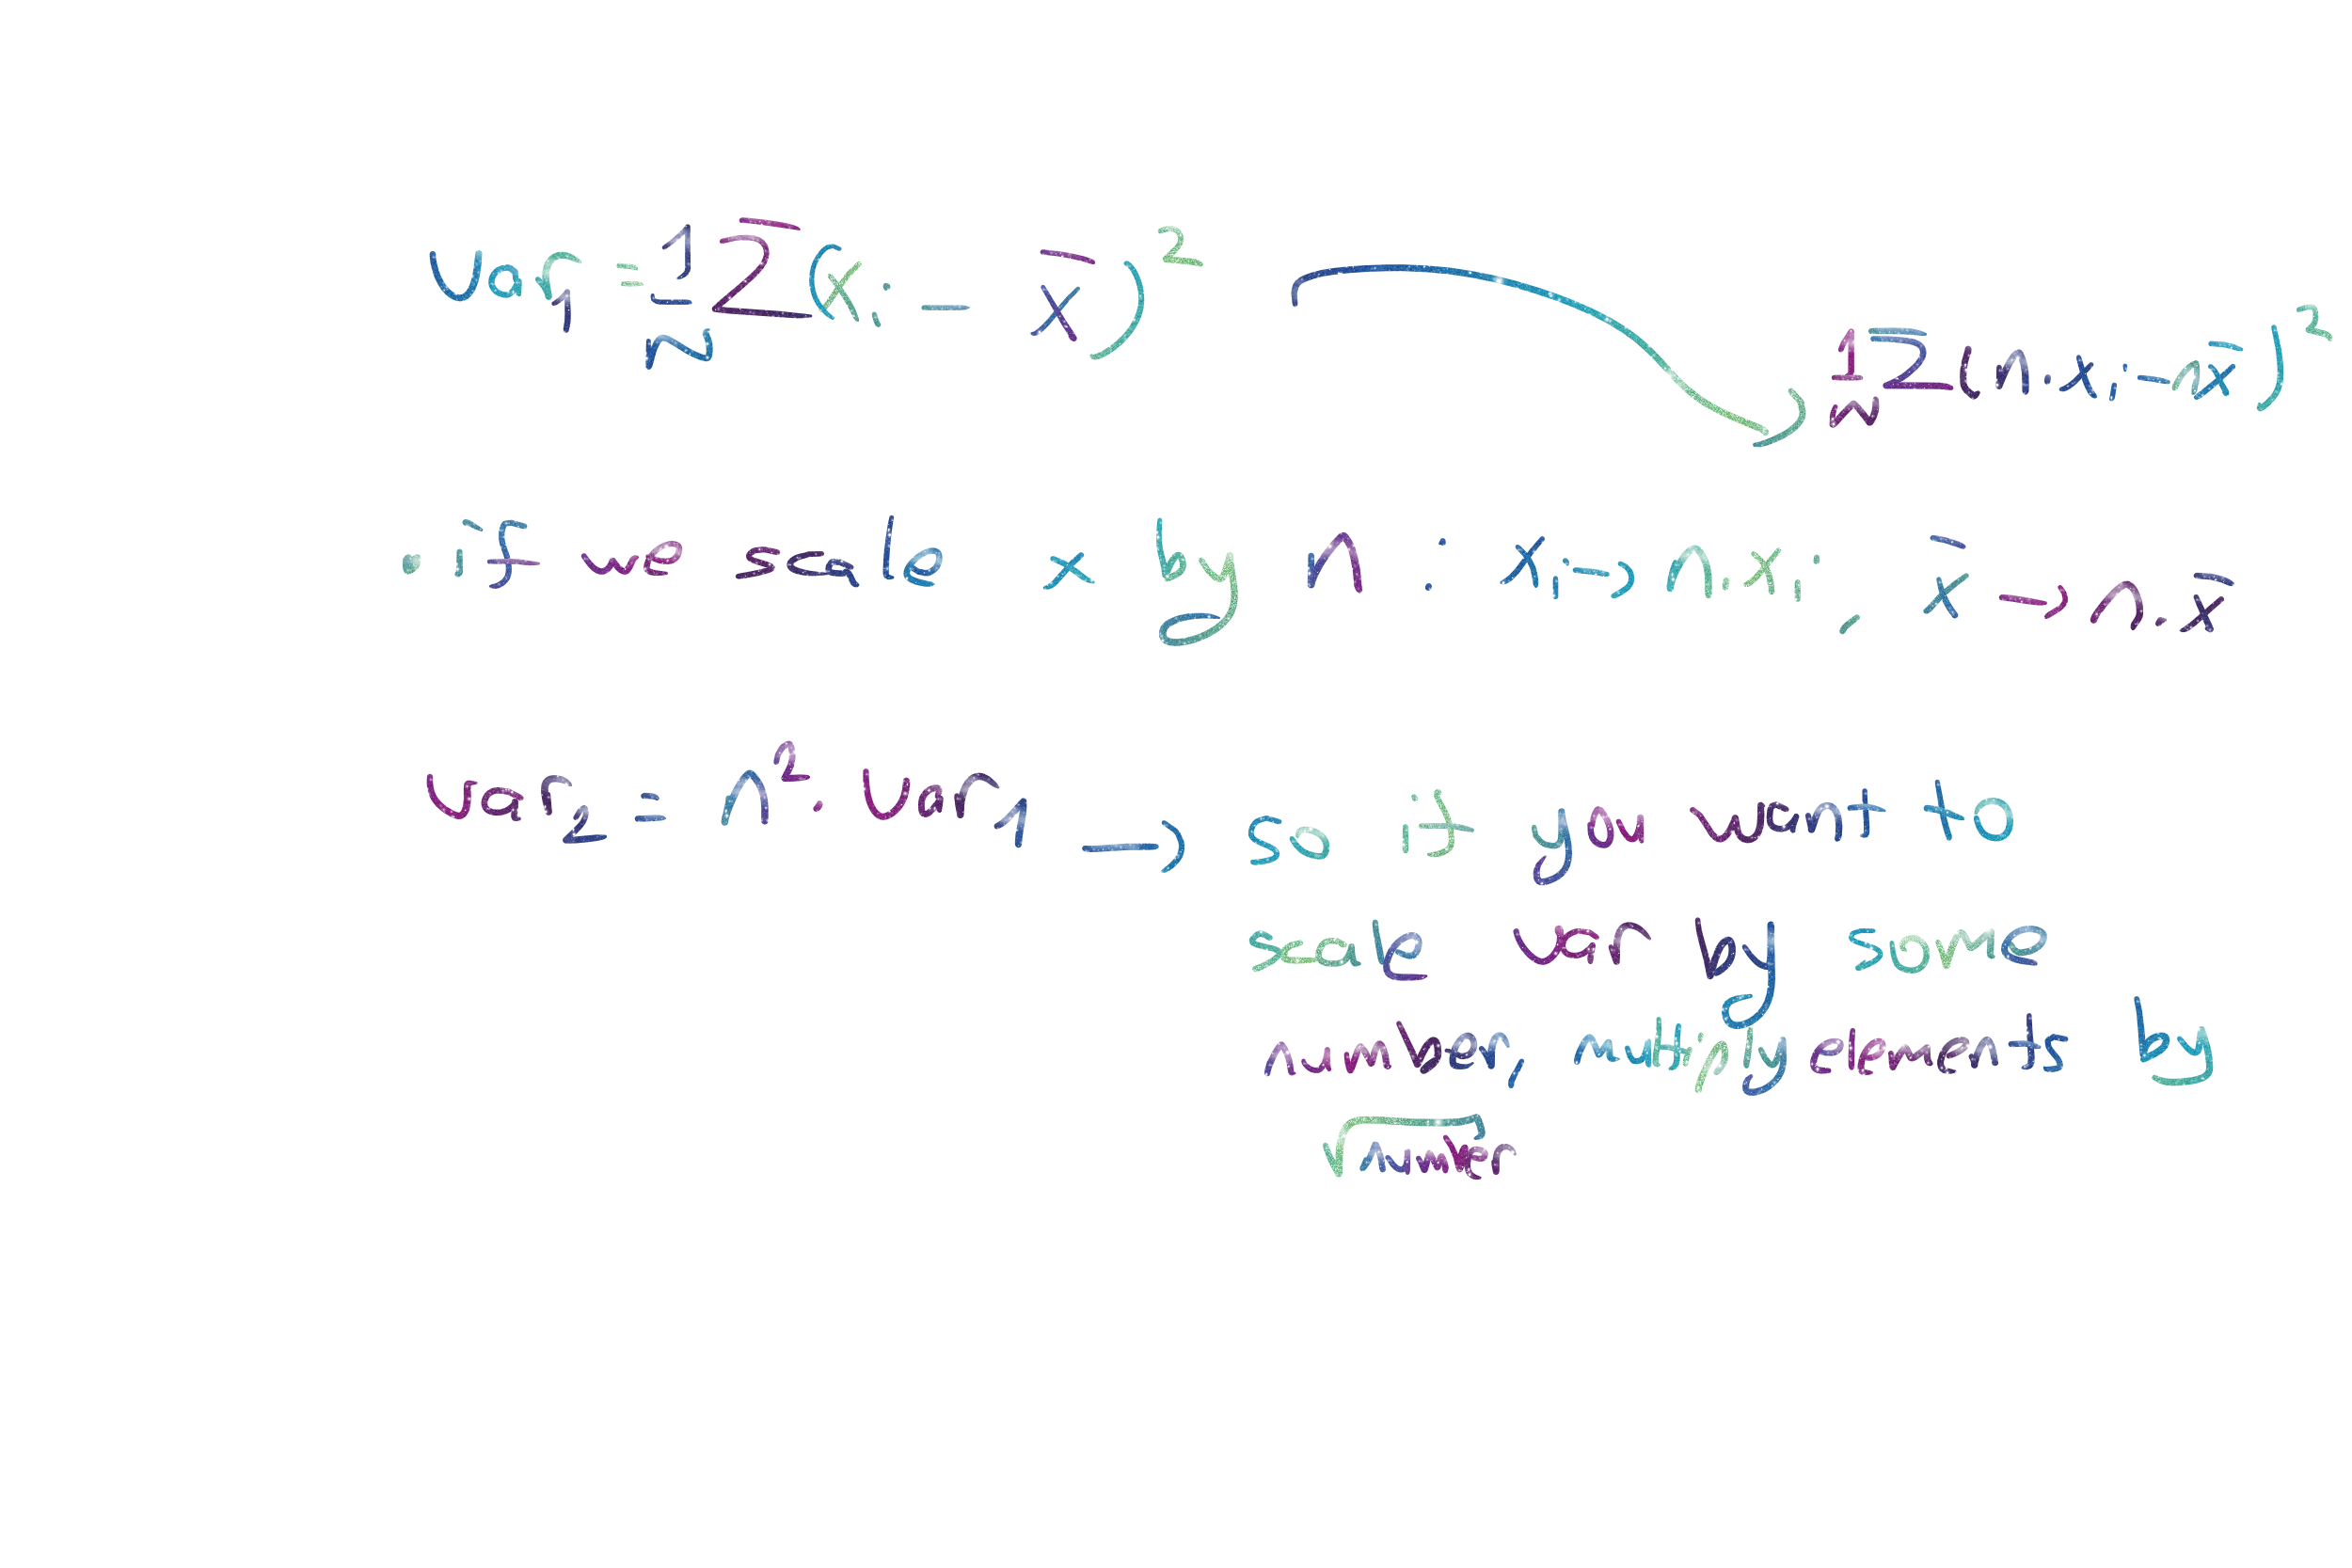

### Init Regarding Variance of Sum of Random Variables

In [302]:
num_elements = l1.weight[0].numel()
num_elements

25

In [304]:
l1.weight.data = init.normal_(l1.weight.data) / math.sqrt(num_elements)

In [305]:
stats(l1.weight)

Mean: 0.001605219324119389, Std: 0.1929323822259903


In [306]:
a1 = l1(x)

In [307]:
stats(a1)

Mean: 0.005814109463244677, Std: 1.0525163412094116


### If we are using ReLU

In [486]:
init.kaiming_normal_(l1.weight, a = 0) # a = 1 is just x = y, so we are now looking no relu at all
stats(l1(x))

Mean: 0.03490150719881058, Std: 1.6050894260406494


In [553]:
num_elements = l1.weight[0,0].shape.numel() 

In [492]:
l1.weight.shape

torch.Size([32, 1, 5, 5])

In [493]:
num_elements

25

In [717]:
def gain(a):
    return math.sqrt(2.0 / (1 + a**2))

In [718]:
a = 0

#### Without gain adjustment

In [548]:
l1.weight.data = init.normal_(l1.weight.data) / math.sqrt(num_elements)

In [549]:
stats(F.leaky_relu_(l1(x), 0))

Mean: 0.38055869936943054, Std: 0.6769595742225647


#### With gain adjustment

In [550]:
l1.weight.data = init.normal_(l1.weight.data) / math.sqrt(num_elements) * gain(a)

In [551]:
stats(F.leaky_relu_(l1(x), 0.2))

Mean: 0.4500739872455597, Std: 1.1660559177398682


### Writing our own kaiming init

In [743]:
# kaiming for uniform init
def kaiming_uniform(x, a):
    n = x[0].shape.numel()
    std = gain(a) / math.sqrt(n)
    bound = math.sqrt(3.) * std
    x.data.uniform_(-bound, bound)

In [744]:
kaiming_uniform(l1.weight, a = 0.5)
stats(F.leaky_relu_(l1(x), 0.5))

Mean: 0.21728722751140594, Std: 1.0196655988693237


In [745]:
# PyTorch default

l1 = nn.Conv2d(1, 32, kernel_size= 5).cuda()
stats(F.leaky_relu_(l1(x), 0))

Mean: 0.2512500286102295, Std: 0.46623778343200684


In [750]:
# kaiming for normal distribution init
def kaiming_norm(x, a):
    n = x[0].shape.numel()
    std = gain(a) / math.sqrt(n)
    x.data = x.data.normal_() * std

In [751]:
kaiming_norm(l1.weight, a = 0)
stats(F.leaky_relu_(l1(x), 0))

Mean: 0.4951242506504059, Std: 0.9265923500061035


## Our init vs PyTorch init

### Adding Customer Functions to nn.Sequential

In [692]:
import torch.nn.functional as F

In [693]:
class Func(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x): 
        return self.func(x)

In [694]:
def flatten(x):      
    return x.view(x.shape[0], -1)

In [695]:
def print_t(x):      
    print(x.shape)
    return x

### CNN Model

* I am giving very basic cnn structure, please feel free to experiment on them. Add pooling, use different optimizers etc and try to increase the performance

In [696]:
model = nn.Sequential(
        nn.Conv2d(1, 8, 5, padding=2,stride=2), nn.ReLU(), #14
        nn.Conv2d(8, 16, 3, padding=1,stride=2), nn.ReLU(), # 7
        nn.Conv2d(16, 32, 3, padding=1,stride=2), nn.ReLU(), # 4
        nn.Conv2d(32, 32, 3, padding=1,stride=2), nn.ReLU(), # 2
        #Func(print_t),
        nn.AdaptiveAvgPool2d(1),
        Func(flatten),
        nn.Linear(32,10)
).cuda()

### std at the end of forward pass

In [697]:
temp = model(x)

In [698]:
stats(temp)

Mean: 0.03649372234940529, Std: 0.11180081218481064


* too little std ! It means nodes are nearly identical so it may hinder optimal learning process 

### Trying with our custom init method

In [764]:
for l in model:
    if isinstance(l, nn.Conv2d):
        kaiming_uniform(l.weight, a = 0)
        l.bias.data.zero_()

In [762]:
temp = model(x)

In [763]:
stats(temp)

Mean: 0.16131894290447235, Std: 0.2585890293121338


### Training with default init:

In [767]:
model = nn.Sequential(
        nn.Conv2d(1, 8, 5, padding=2,stride=2), nn.ReLU(), #14
        nn.Conv2d(8, 16, 3, padding=1,stride=2), nn.ReLU(), # 7
        nn.Conv2d(16, 32, 3, padding=1,stride=2), nn.ReLU(), # 4
        nn.Conv2d(32, 32, 3, padding=1,stride=2), nn.ReLU(), # 2
        #Func(print_t),
        nn.AdaptiveAvgPool2d(1),
        Func(flatten),
        nn.Linear(32,10)
).cuda()

In [768]:
optim = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-3)

In [769]:
train(model,80,10)

0.09883721172809601
0.4650254249572754
0.8958938717842102
0.9193313717842102
0.9348655343055725
0.9425871968269348
0.9396802186965942
0.9537609219551086


### Training with our init

In [765]:
optim = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-3)

In [766]:
train(model,80,10)

0.32076671719551086
0.902888834476471
0.9358648061752319
0.9460392594337463
0.9514898061752319
0.9590297937393188
0.9632993936538696
0.9669331312179565


* Init mattered, and this model is not very deep network, effect can be more visible on deeper networks